In [32]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [33]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Dataset

| Variable | Definition | Note |
| - | - | - |
| `Survived` | Whether the passenger survived | `1` means survived, `0` means didn't survive |
| `Pclass` | Ticket class - a proxy for socio-economic status | `1` means upper class, `2` means middle class, and `3` means lower class |
| `Sex` | Gender - male or female | |
| `Age` | Age in years | For children younger than 1 y/o, the age is fractional.<br>If age is estimated, it has `.5` added. |
| `SibSp` | Count of siblings and/or spouses abroad the Titanic | Siblings include brothers, sisters, stepbrothers, and stepsisters.<br>Spouses include husband or wife (mistresses and fiancés are ignored). |
| `Parch` | Count of parents and/or children abroad the Titanic | Parents include father and mother.<br>Children include son, daughter, stepson, and stepdaughter.<br>Some children travelled only with a nanny, therefore `Parch` is `0` for them. |
| `Ticket` | Ticket number | |
| `Fare` | Passenger fare (in USD) | |
| `Cabin` | Cabin number | |
| `Embarked` | Name of the port from which the passenger went on board to Titanic | `C` means Cherbourg, `Q` means Queenstown, `S` means Southampton |


In [34]:
titanic = pd.read_csv("data/train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data Exploration

In [36]:
modified_titanic = {}

column_names = titanic.columns[~titanic.columns.isin(["Survived", "PassengerId", "Name"])].tolist()

for column_name in column_names:
    surviving_column_name = f"{column_name}_surviving"
    nonsurviving_column_name = f"{column_name}_nonsurviving"

    modified_titanic[surviving_column_name] = titanic[titanic["Survived"] == 1][column_name].reset_index(drop=True)
    modified_titanic[nonsurviving_column_name] = titanic[titanic["Survived"] == 0][column_name].reset_index(drop=True)

modified_titanic = pd.DataFrame(modified_titanic).reset_index(drop=True)

for column in modified_titanic.columns:
    if modified_titanic[column].dtype == "float64":
        if modified_titanic[column].dropna().apply(float.is_integer).all():
            modified_titanic[column] = modified_titanic[column].astype('Int64')

modified_titanic.head()

,Pclass_surviving,Pclass_nonsurviving,Sex_surviving,Sex_nonsurviving,Age_surviving,Age_nonsurviving,SibSp_surviving,SibSp_nonsurviving,Parch_surviving,Parch_nonsurviving,Ticket_surviving,Ticket_nonsurviving,Fare_surviving,Fare_nonsurviving,Cabin_surviving,Cabin_nonsurviving,Embarked_surviving,Embarked_nonsurviving
0,1,3,female,male,38.0,22.0,1,1,0,0,PC 17599,A/5 21171,71.2833,7.2500,C85,NaN,C,S
1,3,3,female,male,26.0,35.0,0,0,0,0,STON/O2. 3101282,373450,7.9250,8.0500,NaN,NaN,S,S
2,1,3,female,male,35.0,NaN,1,0,0,0,113803,330877,53.1000,8.4583,C123,NaN,S,Q
3,3,1,female,male,27.0,54.0,0,0,2,0,347742,17463,11.1333,51.8625,NaN,E46,S,S
4,2,3,female,male,14.0,2.0,1,3,0,1,237736,349909,30.0708,21.0750,NaN,NaN,C,S


### Ticket Class

In [37]:
pclass_surviving_counts = modified_titanic["Pclass_surviving"].value_counts()
pclass_nonsurviving_counts = modified_titanic["Pclass_nonsurviving"].value_counts()

pclass_surviving = pd.DataFrame(pclass_surviving_counts).reset_index()
pclass_surviving.columns = ["Pclass", "Surviving"]

pclass_nonsurviving = pd.DataFrame(pclass_nonsurviving_counts).reset_index()
pclass_nonsurviving.columns = ["Pclass", "Nonsurviving"]

pclass = pd.merge(pclass_surviving, pclass_nonsurviving, on="Pclass", how="outer")
pclass = pclass.sort_values(by="Pclass")
pclass["Survival Likelihood (%)"] = np.round((pclass["Surviving"] - pclass["Nonsurviving"]) / pclass["Nonsurviving"] * 100)

pclass.head()

,Pclass,Surviving,Nonsurviving,Survival Likelihood (%)
0,1,136,80,70.0
2,2,87,97,-10.0
1,3,119,372,-68.0


### Gender

In [38]:
sex_surviving_counts = modified_titanic["Sex_surviving"].value_counts()
sex_nonsurviving_counts = modified_titanic["Sex_nonsurviving"].value_counts()

sex_surviving = pd.DataFrame(sex_surviving_counts).reset_index()
sex_surviving.columns = ["Sex", "Surviving"]

sex_nonsurviving = pd.DataFrame(sex_nonsurviving_counts).reset_index()
sex_nonsurviving.columns = ["Sex", "Nonsurviving"]

sex = pd.merge(sex_surviving, sex_nonsurviving, on="Sex", how="outer")
sex = sex.sort_values(by="Sex")
sex["Survival Likelihood (%)"] = np.round((sex["Surviving"] - sex["Nonsurviving"]) / sex["Nonsurviving"] * 100)

sex.head()

,Sex,Surviving,Nonsurviving,Survival Likelihood (%)
0,female,233,81,188.0
1,male,109,468,-77.0


### Age

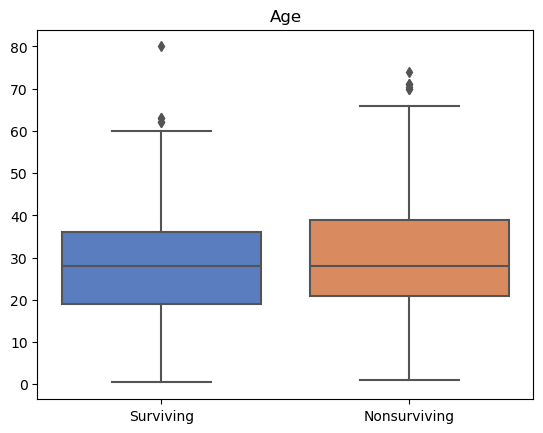

In [39]:
age_surviving = modified_titanic["Age_surviving"]
age_nonsurviving = modified_titanic["Age_nonsurviving"]
age = pd.concat([age_surviving, age_nonsurviving], axis=1)
age.columns = ["Surviving", "Nonsurviving"]

sns.boxplot(age, palette="muted")
plt.title("Age")
plt.show()

### Siblings/Spouses

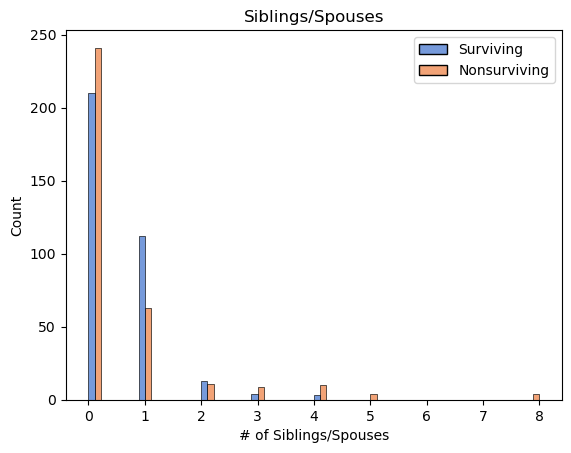

In [40]:
sibsp_surviving = modified_titanic["SibSp_surviving"]
sibsp_nonsurviving = modified_titanic["SibSp_nonsurviving"]

sibsp_surviving = sibsp_surviving[sibsp_surviving.notna()]
sibsp_nonsurviving = sibsp_nonsurviving[sibsp_nonsurviving.notna()]

sibsp = pd.concat([sibsp_surviving, sibsp_nonsurviving], axis=1)
sibsp.columns = ["Surviving", "Nonsurviving"]
sibsp.dropna(inplace=True)

sns.histplot(sibsp, multiple="dodge", palette="muted")
plt.title("Siblings/Spouses")
plt.xlabel("# of Siblings/Spouses")
plt.ylabel("Count")
plt.show()

### Parents/Children

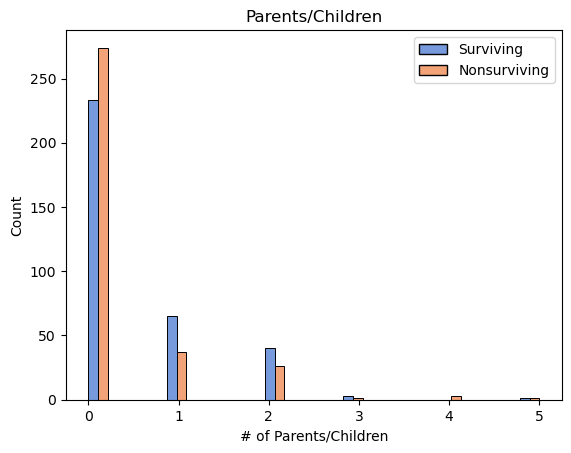

In [41]:
parch_surviving = modified_titanic["Parch_surviving"]
parch_nonsurviving = modified_titanic["Parch_nonsurviving"]

parch_surviving = parch_surviving[parch_surviving.notna()]
parch_nonsurviving = parch_nonsurviving[parch_nonsurviving.notna()]

parch = pd.concat([parch_surviving, parch_nonsurviving], axis=1)
parch.columns = ["Surviving", "Nonsurviving"]
parch.dropna(inplace=True)

sns.histplot(parch, multiple="dodge", palette="muted")
plt.title("Parents/Children")
plt.xlabel("# of Parents/Children")
plt.ylabel("Count")
plt.show()

### Ticket Fare

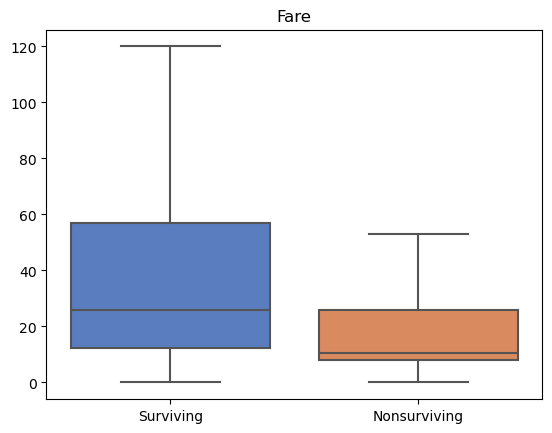

In [42]:
fare_surviving = modified_titanic["Fare_surviving"]
fare_nonsurviving = modified_titanic["Fare_nonsurviving"]
fare = pd.concat([fare_surviving, fare_nonsurviving], axis=1)
fare.columns = ["Surviving", "Nonsurviving"]

sns.boxplot(fare, palette="muted", showfliers=False)
plt.title("Fare")
plt.show()

### Embarked Port

In [43]:
embarked_surviving_counts = modified_titanic["Embarked_surviving"].value_counts()
embarked_nonsurviving_counts = modified_titanic["Embarked_nonsurviving"].value_counts()

embarked_surviving = pd.DataFrame(embarked_surviving_counts).reset_index()
embarked_surviving.columns = ["Embarked", "Surviving"]

embarked_nonsurviving = pd.DataFrame(embarked_nonsurviving_counts).reset_index()
embarked_nonsurviving.columns = ["Embarked", "Nonsurviving"]

embarked = pd.merge(embarked_surviving, embarked_nonsurviving, on="Embarked", how="outer")
embarked = embarked.sort_values(by="Embarked")
embarked["Survival Likelihood (%)"] = np.round((embarked["Surviving"] - embarked["Nonsurviving"]) / embarked["Nonsurviving"] * 100)

embarked.head()

,Embarked,Surviving,Nonsurviving,Survival Likelihood (%)
1,C,93,75,24.0
2,Q,30,47,-36.0
0,S,217,427,-49.0


### Observations

From this data exploration, it is evident that:

- Upper class passengers (`Pclass=1`) were very likely to survive (survival likelihood of $70\%$).
- Middle class passengers (`Pclass=2`) were slightly more likely to **not** survive (surival likelihood of $-10\%$).
- Lower class passengers (`Pclass=3`) were very likely to **not** survive (survival likelihood of $-68\%$).
- Female passengers (`Gender="female"`) were very likely to survive (survival likelihood of $188\%$).
- Male passengers (`Gender="male"`) were very likely to **not** survive (survival likelihood of $-77\%$).
- Older passengers (in terms of `Age`) were slightly more likely to **not** survive.
- Passengers with no siblings/spouses (`SibSp=0`) were more likely to **not** survive.
- Passengers with just one siblings/spouses (`SibSp=1`) were very likely to survive.
- Passengers with two siblings/spouses (`SibSp=2`) were slightly more likely to survive.
- Passengers with more than two siblings/spouses (`SibSp>2`) were more likely to **not** survive.
- Passengers with no parents/children (`Parch=0`) were more likely to **not** survive.
- Passengers with one or more parents/children (`Parch>0`) were generally more likely to survive.
- Passengers with larger ticket fares (in terms of `Fare`) were more likely to survive.
- Passengers who embarked from Cherbourg (`Embarked="C"`) were more likely to survive (survival likelihood of $24\%$).
- Passengers who embarked from Queenstown (`Embarked="Q"`) were more likely to **not** survive (survival likelihood of $-36\%$).
- Passengers who embarked from Southampton (`Embarked="S"`) were more likely to **not** survive (survival likelihood of $-49\%$).

**Note**: The columns `PassengerId` and `Name` are ignored because they hold no useful information. The columns `Ticket` and `Cabin` are also ignored in this version because they are complex strings that are difficult to process (*I do believe that `Cabin` is a useful feature and in a future version, I will decompose it to create some useful features*).

## Data Imputation

In [44]:
missing_counts = titanic.isna().sum()
missing_df = pd.DataFrame(missing_counts).transpose()
missing_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,0,177,0,0,0,0,687,2


### Age

The only features which can meaningfully relate to age are:

- `Pclass`: Rich people are usually older (it takes time to build a large fortune).
- `SibSp`: Older people are more likely to travel without siblings and usually have at most one spouse. And if they are younger, they are likely travelling with their parents, who paid for them, and therefore, likely have siblings, who are also travelling with them.
- `Parch`: Younger people will likely travel with both their parents and have no children. Middle aged people (~30) will travel without their parents and would no children. Older people will have children, who they have brought with them to travel.

We can verify for correlation among these features, and discover a linear relationship. We can then use this linear relationship to impute the missing values in the `"Age"` column.

In [45]:
relevant_features_for_age = ["Age", "Pclass", "SibSp", "Parch"]
relevant_features = titanic[relevant_features_for_age].copy()
corr_matrix = relevant_features.corr()
age_corr = corr_matrix["Age"].sort_values(ascending=True)
age_corr.drop("Age", inplace=True)
age_corr.head()

Pclass   -0.369226
SibSp    -0.308247
Parch    -0.189119
Name: Age, dtype: float64

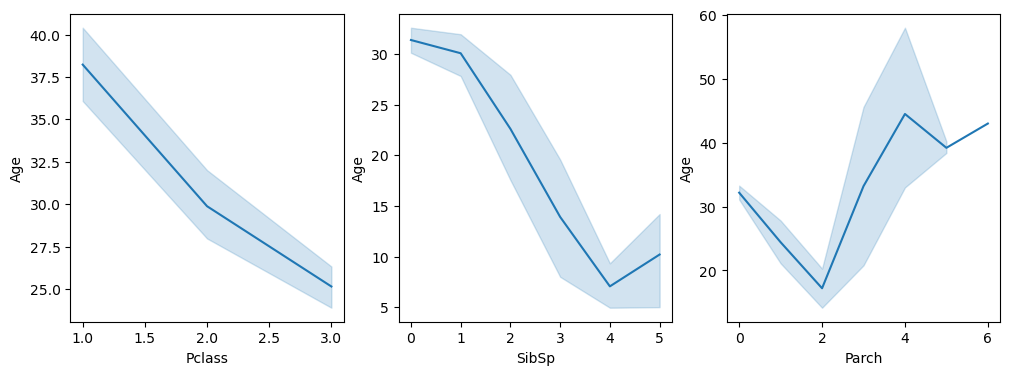

In [46]:
valid_data = relevant_features.dropna(subset=["Age"])
X = valid_data.drop("Age", axis=1)
y = valid_data["Age"].copy()

plt.figure(figsize=(12,4))
plt.subplot(131); sns.lineplot(x=X["Pclass"], y=y)
plt.subplot(132); sns.lineplot(x=X["SibSp"], y=y)
plt.subplot(133); sns.lineplot(x=X["Parch"], y=y)
plt.show()

In [47]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [48]:
coef = np.insert(model.coef_, 0, model.intercept_, axis=0)
print(coef)

[45.90387669 -6.06692195 -3.94979852 -1.41460179]


In [49]:
def impute_age(row):
    age = row[0]
    if pd.isna(age):
        age = np.round(coef[0] + coef[1] * row[1] + coef[2] * row[2] + coef[3] * row[3])
    return age

In [50]:
titanic["Age"] = titanic[relevant_features_for_age].apply(impute_age, axis=1)

missing_counts = titanic.isna().sum()
missing_df = pd.DataFrame(missing_counts).transpose()
missing_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,0,0,0,0,0,0,687,2


### Embarked Port

There are only 2 missing values in the `"Embarked"` column. We can simply replace them with the most frequent value in this column. This is justifiable since there are only 3 ports to choose from.

In [51]:
most_frequent_value = titanic["Embarked"].mode()[0]
titanic["Embarked"].fillna(most_frequent_value, inplace=True)

missing_counts = titanic.isna().sum()
missing_df = pd.DataFrame(missing_counts).transpose()
missing_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,0,0,0,0,0,0,687,0


## Feature Engineering

- All columns except for `Sex` and `Embarked` are numeric, so they work fine with machine learning algorithms.
- Both of these columns are categorical, they can be one-hot encoded. 

In [52]:
X = titanic.drop(["PassengerId", "Name", "Ticket", "Cabin", "Survived"], axis=1)
y = titanic["Survived"]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [53]:
X = pd.get_dummies(X, columns=["Sex"], prefix="Sex", dtype=float)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,3,22.0,1,0,7.2500,S,0.0,1.0
1,1,38.0,1,0,71.2833,C,1.0,0.0
2,3,26.0,0,0,7.9250,S,1.0,0.0
3,1,35.0,1,0,53.1000,S,1.0,0.0
4,3,35.0,0,0,8.0500,S,0.0,1.0


In [54]:
X = pd.get_dummies(X, columns=["Embarked"], prefix="Embarked", dtype=float)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


## Preprocessing Pipeline

These are reasonable features to pass to a machine learning algorithm. However, we need to perform the same steps on the test set as well. To make this manageable, we make a preprocessing pipeline (`sklearn.pipeline.Pipeline`). There are only two additional steps:

- The feature vector is converted to a numpy array.
- The feature vector is scaled using a `StandardScaler` (`sklearn.preprocessing.StandardScaler`).

In [55]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.attribute_names]

In [56]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, relevant_features_for_age):
        self.relevant_features_for_age = relevant_features_for_age

    def fit(self, X, y=None):
        relevant_features = X[self.relevant_features_for_age].copy()
        valid_data = relevant_features.dropna(subset=["Age"])
        X_ = valid_data.drop("Age", axis=1)
        y_ = valid_data["Age"].copy()

        model_ = LinearRegression()
        model_.fit(X_, y_)
        self.coef_ = np.insert(model_.coef_, 0, model_.intercept_, axis=0)
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_["Age"] = X[self.relevant_features_for_age].apply(self.impute_age, axis=1)
        return X_

    def impute_age(self, cols):
        age = cols[0]
        if pd.isna(age):
            age = np.round(coef[0] + coef[1] * cols[1] + coef[2] * cols[2] + coef[3] * cols[3])
        return age

In [57]:
class FareImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.average_value = X["Fare"].mean()
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_["Fare"].fillna(self.average_value, inplace=True)
        return X_

In [58]:
class EmbarkedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.most_frequent_value = X["Embarked"].mode()[0]
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_["Embarked"].fillna(self.most_frequent_value, inplace=True)
        return X_

In [59]:
class OneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = pd.get_dummies(X_, columns=[self.column_name], prefix=self.column_name, dtype=float)
        return X_

In [60]:
class ToNumpy(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        return X_.values

In [61]:
good_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
relevant_features_for_age = ["Age", "Pclass", "SibSp", "Parch"]

preprocessing_pipeline = Pipeline([
    ("feature_selector", FeatureSelector(good_features)),
    ("age_imputer", AgeImputer(relevant_features_for_age)),
    ("fare_imputer", FareImputer()),
    ("embarked_imputer", EmbarkedImputer()),
    ("sex_encoder", OneHotEncoder("Sex")),
    ("embarked_encoder", OneHotEncoder("Embarked")),
    ("to_numpy", ToNumpy()),
    ("std_scaler", StandardScaler()),
    
])

## Model Selection

In [62]:
titanic = pd.read_csv("data/train.csv")

X_train_raw = titanic.drop(["Survived"], axis=1)
y_train = titanic["Survived"].values
X_train_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [63]:
X_train = preprocessing_pipeline.fit_transform(X_train_raw)
X_train.shape

(891, 10)

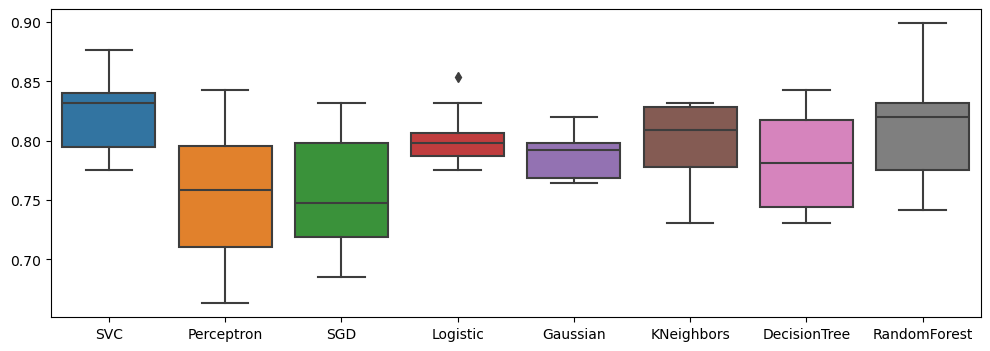

In [64]:
svc = SVC()
per = Perceptron()
sgd = SGDClassifier()
log = LogisticRegression()
gau = GaussianNB()
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

clfs = {
    "SVC": svc,
    "Perceptron": per,
    "SGD": sgd,
    "Logistic": log,
    "Gaussian": gau,
    "KNeighbors": knc,
    "DecisionTree": dtc,
    "RandomForest": rfc
}

scores = {}
for name, clf in clfs.items():
    score = cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy")
    scores[name] = score
scores = pd.DataFrame(scores)

plt.figure(figsize=(12, 4))
sns.boxplot(scores)
plt.show()

### Observations

- It can be clearly seen that `SVC` and `RandomForestClassifer` are the most promising models.
- We can now run a grid search to find best parameters for `SVC` and `RandomForestClassifier`.

### SVC

In [65]:
param_grid = {
    "C": [1, 10],
    "kernel": ["linear", "poly", "rbf"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3],
    "random_state": [42],
}

svc = SVC()
grid_search_svc = GridSearchCV(svc, param_grid, scoring="accuracy", cv=5)
grid_search_svc.fit(X_train, y_train)

print(f"Best parameters: {grid_search_svc.best_params_}")
print(f"Best score: {grid_search_svc.best_score_}")

Best parameters: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 42}
Best score: 0.821542903772519


### RandomForestClassifier

In [66]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_features": ["log2"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2],
    "random_state": [42],
}

rfc = RandomForestClassifier()
grid_search_rfc = GridSearchCV(rfc, param_grid, scoring="accuracy", cv=5)
grid_search_rfc.fit(X_train, y_train)

print(f"Best parameters: {grid_search_rfc.best_params_}")
print(f"Best score: {grid_search_rfc.best_score_}")

Best parameters: {'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
Best score: 0.8339150084740442


## Prediction

In [68]:
test_data = pd.read_csv("data/test.csv")

X_test_raw = test_data.copy()
X_test_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [69]:
X_test = preprocessing_pipeline.fit_transform(X_test_raw)
X_test.shape

(418, 10)

In [70]:
model = grid_search_rfc.best_estimator_
predictions = model.predict(X_test)
predictions.shape

(418,)

In [71]:
output = pd.DataFrame({"PassengerId": test_data.PassengerId, "Survived": predictions})
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [72]:
output.to_csv("res/submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
